In [ ]:
%pip install sklearn scikit-image h5py

In [2]:
# load data
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tqdm

# map
with open("data02/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])


In [51]:
# Create descriptors
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray

# Initialize the ORB descriptor
descriptor_extractor = ORB(n_keypoints=10000)
# Initialize the data structure that will contain all the descriptors
descriptors = []
responses = []

# Loop over map images
for img_name in m_imgs:
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)  
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    responses_img = descriptor_extractor.responses
    # Accumulate the computed descriptors
    descriptors.append(descriptors_img)
    responses.append(responses_img)

In [1]:
import pickle
# save descriptors (uncomment if you want to save the computed descriptors)
#f = open('./ORB-descriptors-original.bin', 'wb')
#data = pickle.dump(descriptors, f)
#f.close()

# load pre-computed descriptors
f = open('./ORB-descriptors-original.bin', 'rb')
descriptors = pickle.load(f)
f.close()

# Ns for which a subset is created
ns = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
descriptors_ns = [] # will contain subsets of the descriptors for each N in Ns
for n in ns:
    descriptors_n = []
    for index in range(len(descriptors)):
        best_indices = responses[index].argsort()[::-1][:n]
        descriptors_n.extend(descriptors[index][best_indices])
    descriptors_ns.append(descriptors_n)


In [ ]:
import sklearn
from sklearn.cluster import KMeans

# clustering
K = 32  # number of clusters (equivalent to the number of words) we want to estimate
num_initialization = 5 # Number of time the k-means algorithm will be run with different centroid seeds.

# Run the k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=1)
clusters = kmeans.fit(descriptors_ns[8])  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_

print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")
# Rememeber: the centroids can be considered as the words that compose our documents 
# -> in this case the basic components of the images

In [76]:
#f = open('./knn_centroids_8.bin', 'wb')
#data = pickle.dump(centroids, f)
#f.close()

# load pre-computed descriptors
f = open('./knn_32_centroids_9.bin', 'rb')
centroids = pickle.load(f)
f.close()

In [9]:
from sklearn.metrics import pairwise_distances_argmin_min
# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    for i in range(n_descriptors):
        ## BEGIN ANSWER
        descriptor = img_descriptors[i]
        
        centroid_index, _ = pairwise_distances_argmin_min(descriptor.reshape(1, -1), centroids)
        bow_vector[centroid_index[0]] += 1
            
        ## END ANSWER
    return bow_vector

In [ ]:
from skimage.feature import ORB
from tqdm import tqdm
from skimage.color import rgb2gray
import pickle

descriptor_extractor = ORB(n_keypoints=10000)
#ns = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
ns = [50, 100, 500, 1000, 1500, 2000]
bow_map_images = None
bow_map_images_ns = {}

n = 1500
i = 7

f = open('./knn_32_centroids_' + str(i) + '.bin', 'rb')
centroids = pickle.load(f)
f.close()

# loop over the images in the map set
for img_name in tqdm(m_imgs):
    # load image
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)  
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    responses_img = descriptor_extractor.responses
    
    best_indices = responses_img.argsort()[::-1][:n]
    img_descriptors = descriptors_img[best_indices]

    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
        # add the computed BoW vector to the set of map representations
    if n in bow_map_images_ns:
        arr = bow_map_images_ns[n]
        arr = np.vstack((arr, bow))
        bow_map_images_ns[n] = arr
    else:
        bow_map_images_ns[n] = bow

In [11]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
# receives as input the:
#   - bag of words vectors of the map images
#   - the bag of work vector of the query image
from sklearn.metrics import pairwise_distances
from sklearn import preprocessing
import h5py
import numpy as np
import pickle
from skimage.feature import ORB
import matplotlib.pyplot as plt
import json
from skimage.color import rgb2gray
from tqdm import tqdm

ns = [50, 100, 500, 1000, 1500, 2000]
ks = [8, 16, 32, 48]

with open("data02/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])

# loading the relevance judgements
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

for n in tqdm(ns):
    for k in ks:
        # load pre-computed descriptors
        f = open('./bows/bows_k' + str(k) + '_n' + str(n) + '.bin', 'rb')
        bow_map_images = pickle.load(f)
        f.close()

        # load pre-computed centroids
        f = open('./centroids/centroids_k' + str(k) + '_n' + str(n) + '.bin', 'rb')
        centroids = pickle.load(f)
        f.close()

        # Compute z-score statistics
        scaler = preprocessing.StandardScaler().fit(bow_map_images)
        # Normalize the vectors of the map collection (0 mean and 1 std)
        bow_map_images = scaler.transform(bow_map_images)

        descriptor_extractor = ORB(n_keypoints=n)

        def retrieve_images(map_bow_vectors, query_bow):
            n_map_bow_vectors = map_bow_vectors.shape[0]
            bow_distances = np.zeros(n_map_bow_vectors)
            most_similar = None  # use this to 

            ## BEGIN ANSWER
            bow_distances = pairwise_distances(query_bow.reshape(1, -1), map_bow_vectors)[0]
            most_similar = bow_distances.argsort()
            ## END ANSWER

            return most_similar



        # Retrieve the most similar images to query image 221 (index 221-1=220)
        rel_img = []
        retr_img = []
        for index, img_name in enumerate(q_imgs): 
            img = plt.imread(os.path.join('data02/', img_name))
            img = rgb2gray(img)
            # compute bag of words
            descriptor_extractor.detect_and_extract(img)  
            query_img_descriptors = descriptor_extractor.descriptors 
            bow = bag_of_words(centroids, query_img_descriptors)

            # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
            bow = scaler.transform(bow.reshape(-1, 1).transpose())
            bow = bow.transpose().reshape(-1)

            # Retrieve the indices of the top-10 similar images from the map
            retrieved_images = retrieve_images(bow_map_images, bow)
            relevant_images = np.where(sim[index, :] == 1)[0]
            rel_img.append(relevant_images)
            retr_img.append(retrieved_images)
        
        print('k = ', k, ' n = ', n, ': ', mapk(rel_img, retr_img))

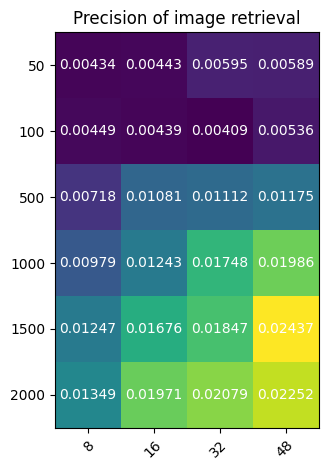

In [27]:
import numpy as np
import matplotlib.pyplot as plt

y = ['50', '100', '500', '1000', '1500', '2000']
x = ['8', '16', '32', '48']
precisions = np.array([[0.004338319160997733, 0.004433845427059712, 0.00594662037037037, 0.005886552658100277],
[0.004486001511715797, 0.004393170194003528, 0.004088875661375661, 0.005360820105820106],
[0.007177804232804232, 0.010812219702695892, 0.01112324074074074, 0.011753805744520032],
[0.009786005291005291, 0.012425674603174602, 0.01747789241622575, 0.01985977796674225],
[0.012473655517762661, 0.016757981859410433, 0.01847137566137566, 0.024371046863189718],
[0.013487453703703703, 0.019706296296296298, 0.0207886079617032, 0.022520767195767198]])

fig, ax = plt.subplots()
im = ax.imshow(precisions)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x)), labels=x)
ax.set_yticks(np.arange(len(y)), labels=y)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, round(precisions[i, j], 5),
                       ha="center", va="center", color="w")

ax.set_title("Precision of image retrieval")
fig.tight_layout()
plt.show()